In [1]:
import datetime
# Get the current date and time
now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M")

## Load data

Change the column name at line 9 to one of the columns in the dataset to set the forcasting target.

In [2]:
import pandas as pd

# Load your sequential data of electricity demand
# Assuming your data is in a CSV file, with 'demand' column representing the electricity demand
data = pd.read_csv("./data/NET.csv")

data['Target'] = data['Net Demand']


## Autocorrelation

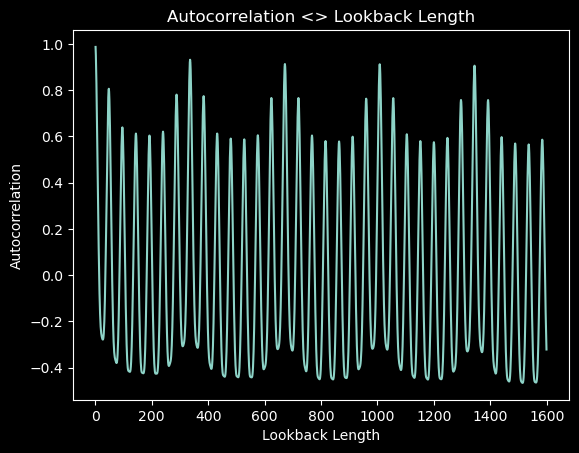

Best Lookback Length: 336


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate autocorrelation for different lookback lengths
lookback_lengths = range(1, 1600)
autocorrelation_values = []
for lookback in lookback_lengths:
  autocorrelation = data['Target'].autocorr(lag=lookback)
  autocorrelation_values.append(autocorrelation)

# Plot autocorrelation values
plt.plot(lookback_lengths, autocorrelation_values)
plt.xlabel('Lookback Length')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation <> Lookback Length')
plt.show()

# Sort the autocorrelation values in descending order
sorted_autocorrelation_values = sorted(autocorrelation_values, reverse=True)

best_lookback_length = max([lookback for lookback in lookback_lengths if lookback > 2], key=lambda x: autocorrelation_values[x-1])
print('Best Lookback Length:', best_lookback_length)


## Data transformation

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

# Subtract the average from the data
target_avg = data['Target'].mean()
target_avg = 0 # Hardcoded average demand, 0 means no subtraction
print("Average demand: ", target_avg)
data['Target'] = data['Target'] - target_avg

# Normalize the data
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
data['Target'] = scaler.fit_transform(data['Target'].values.reshape(-1,1))
joblib.dump(scaler, f'./scaler/scaler_{timestamp}.pkl')

Average demand:  0


['./model/scaler_20240325_1527.pkl']

## Prepare data for training

In [5]:

# Function to create dataset with sequences of 48 demand values
def create_dataset(dataset, weeks=0, days=0, periods=48):
    look_back=periods + (days * 48) + (weeks * 7 * 48)
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back)])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

# Split data into training and testing sets
train_size = int(len(data) * 0.75)
validate_size = int(len(data) * 0.1)
test_size = len(data) - train_size - validate_size
train, validate, test = data.iloc[0:train_size], \
                        data.iloc[train_size:train_size+validate_size], \
                        data.iloc[train_size+validate_size:len(data)]

# Create datasets for training and testing
weeks = 1
days = 0
periods = 0
train_X, train_Y = create_dataset(train['Target'].values, weeks=weeks, days=days, periods=periods)
validate_X, validate_Y = create_dataset(validate['Target'].values, weeks=weeks, days=days, periods=periods)
test_X, test_Y = create_dataset(test['Target'].values, weeks=weeks, days=days, periods=periods)

print("Train X shape: ", train_X.shape)

Train X shape:  (9348, 336)


In [6]:
# Reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

print("Shape of train_X:", train_X.shape)
print("Shape of test_X: ", test_X.shape)


Shape of train_X: (9348, 336, 1)
Shape of test_X:  (1601, 336, 1)


## LSTM

In [7]:
import tensorflow as tf

tf.keras.utils.disable_interactive_logging()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2024-03-25 15:27:10.430091: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 15:27:10.430120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 15:27:10.431063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 15:27:10.436621: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 15:27:11.100975: W tensorflow/compiler/tf2

Num GPUs Available:  1


2024-03-25 15:27:11.577481: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 15:27:11.611753: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 15:27:11.611998: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import keras.optimizers as optimizers

model = Sequential()
model.add(LSTM(336, input_shape=(train_X.shape[1], 1), return_sequences=True))
model.add(LSTM(48, dropout=0.1))
model.add(Dense(4, activation='sigmoid'))
model.add(Dense(1))

optimizer = optimizers.get("Adam")
optimizer.learning_rate = 0.001

model.compile(optimizer=optimizer, loss='mse')
model.fit(train_X, train_Y, epochs=100, batch_size=32, verbose=0, validation_data=(validate_X, validate_Y))

2024-03-25 15:27:11.623146: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 15:27:11.623401: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 15:27:11.623565: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

loss        0.002956
val_loss    0.010051
Name: 99, dtype: float64


<Axes: >

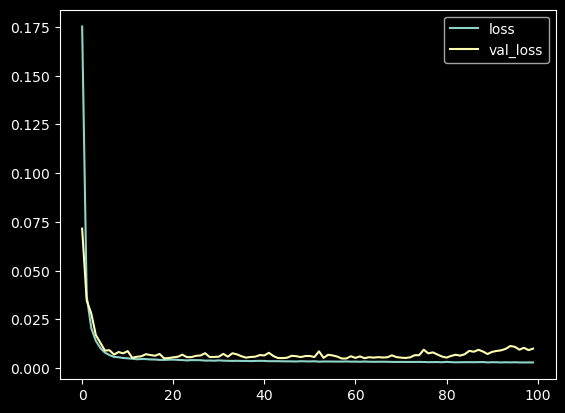

In [9]:
columns = [h for h in model.history.history.keys() if 'loss' in h]
loss_history = [ model.history.history[c] for c in columns ]
loss_history = pd.DataFrame(loss_history).T
loss_history.columns = columns
print(loss_history.iloc[-1])
loss_history.plot()

In [10]:
# Define the filename
filename = f"./model/lstm_{timestamp}.keras"

# Save the model
model.save(filename)


## Predict & Evaluate

In [11]:
from sklearn.metrics import mean_squared_error

# Make predictions
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# Invert predictions to original scale
i_train_predict = scaler.inverse_transform(train_predict) + target_avg
i_train_Y = scaler.inverse_transform([train_Y]) + target_avg
i_test_predict = scaler.inverse_transform(test_predict) + target_avg
i_test_Y = scaler.inverse_transform([test_Y]) + target_avg


# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(i_train_Y[0], i_train_predict[:,0]))
test_score = np.sqrt(mean_squared_error(i_test_Y[0], i_test_predict[:,0]))

Train RMSE: 28.58235391226422


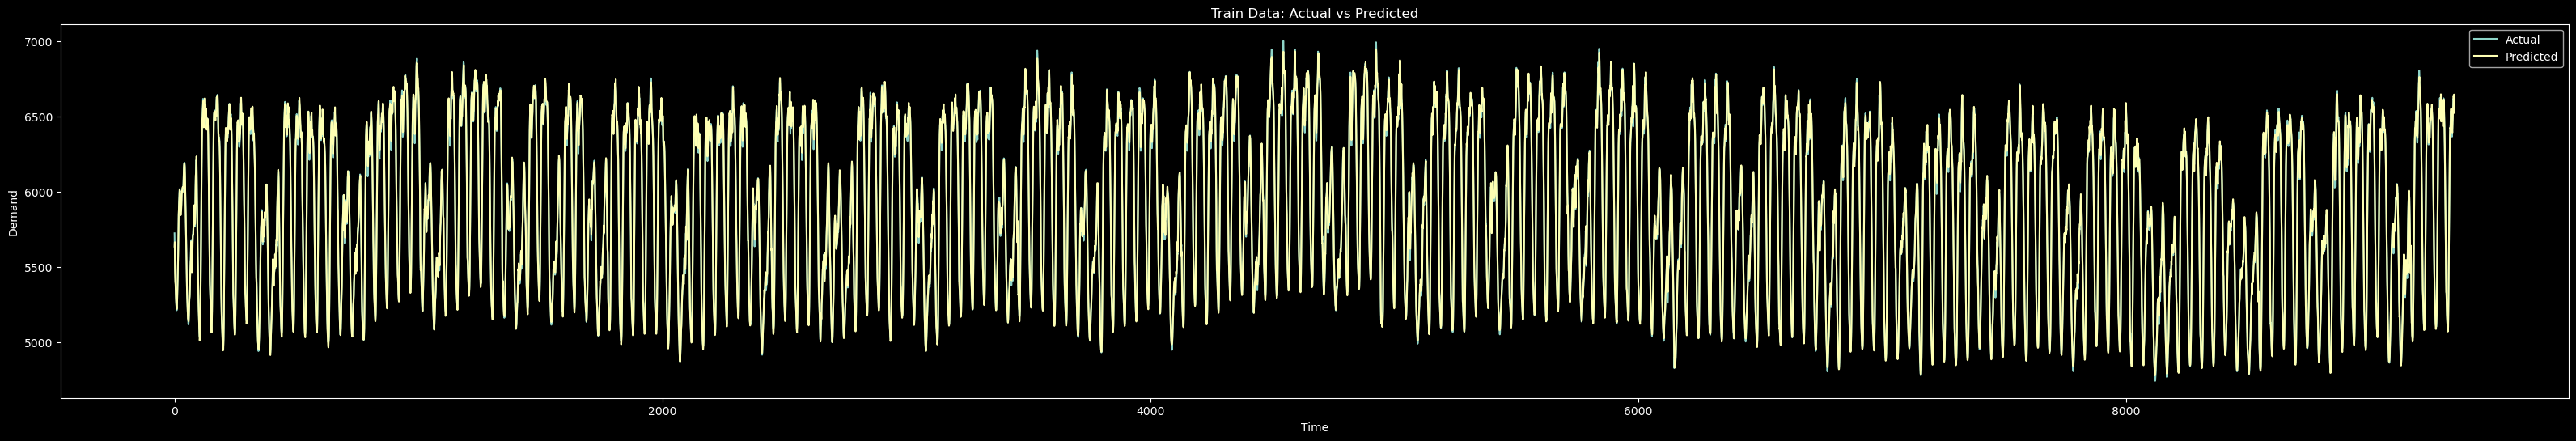

Test RMSE: 49.50105331053119


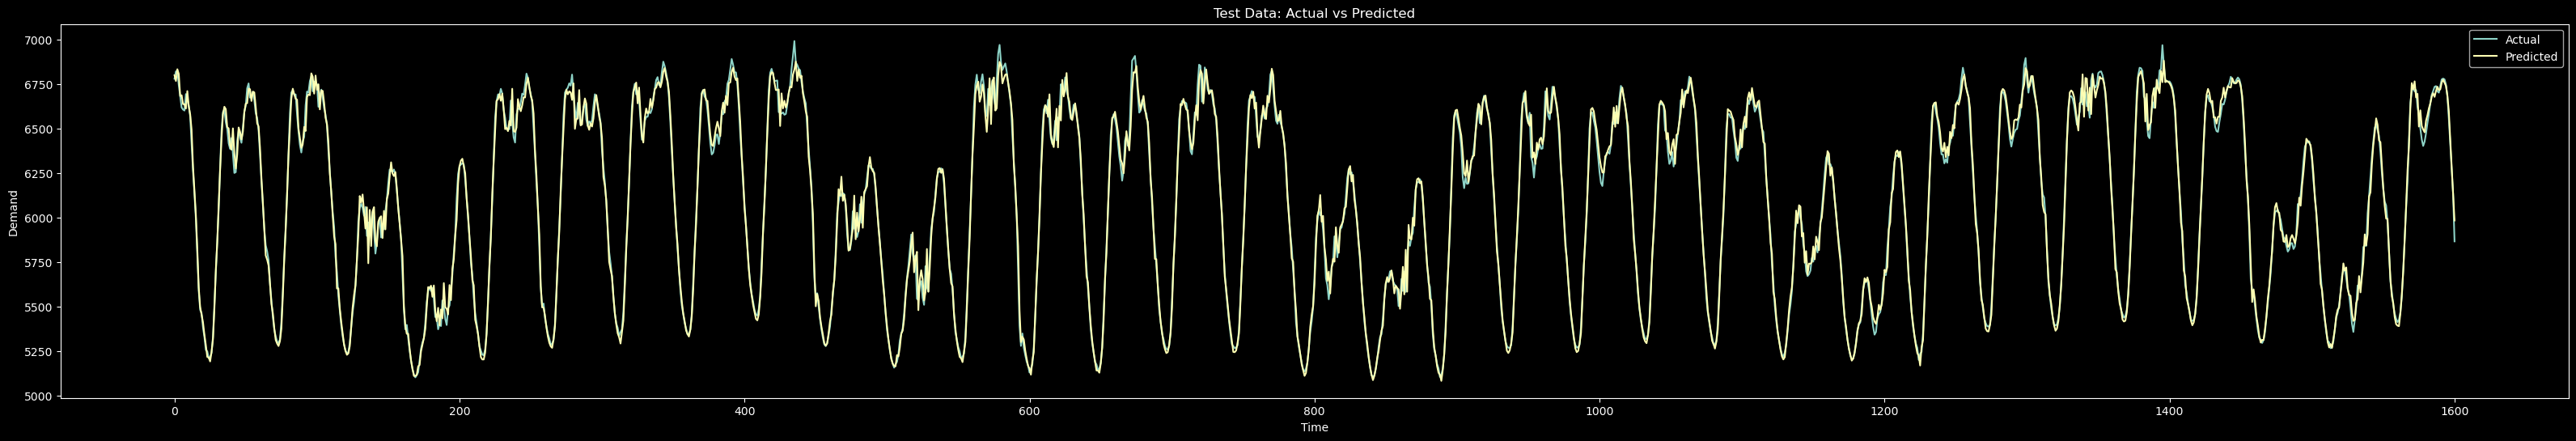

In [12]:
import matplotlib.pyplot as plt

print('Train RMSE:', train_score)

# Plot train data
plt.figure(figsize=(40, 6))
plt.plot(i_train_Y[0], label='Actual')
plt.plot(i_train_predict[:, 0], label='Predicted')
plt.title('Train Data: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

print('Test RMSE:', test_score)

# Plot test data
plt.figure(figsize=(40, 6))
plt.plot(i_test_Y[0], label='Actual')
plt.plot(i_test_predict[:, 0], label='Predicted')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()


In [13]:
# for i in range(50):
#     print(f"test_Y[{i:03d}]: {i_test_Y[0][i]:.12f}, test_predict[{i:03d}]: {i_test_predict[i][0]:.12f}, diff: {abs(i_test_predict[i][0] - i_test_Y[0][i]):.12f}")